### implementing a GPT model from Scratch to Generate Text

In [1]:
from importlib.metadata import version

import matplotlib, tiktoken, torch

print("matplotlib ver:", version("matplotlib"), "tiktoken ver:", version("tiktoken"), "torch:", version("torch"))


matplotlib ver: 3.7.2 tiktoken ver: 0.6.0 torch: 2.1.2


- In this chapter, we implement a GPT-like LLM architecture; the next chapter will focus on training this LLM
- 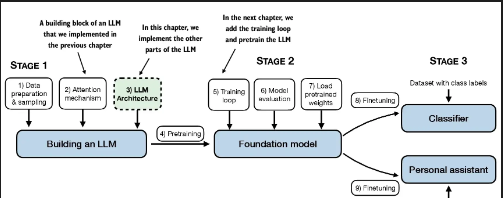

## ***Coding an LLM architecture***
- Compared to conventional deep learning models, LLms are larger, mainly due to their vast number of parameters, not the amount of code.
- 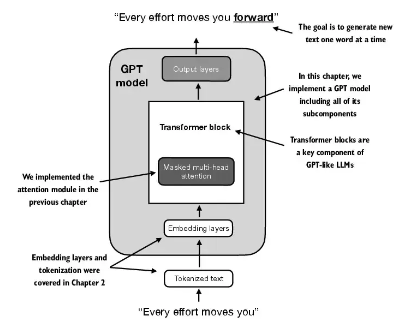
- In prev chapters, we used small embedding dimensions for token inputs and outputs for ease of illustration, ensuring they fit on a single page
- In this chapter, we consider embedding and model size akin to small GPT-2 model
- We'll specifically code the architecture of the smallest GPT-2 model (124m params). 
- Chapter 6 will show how to load pretrained weights into our implementation, which will be compatible with model sizes of 345, 762 and 1542 mill params

- Config details for the 124 million parameter GPT-2 model include:

In [8]:
GPT_CONFIG_124M = {
    "vocab_size"     : 50257,   # Supported by BPE tokenizer 
    "context_length" : 1024,    # Rep the models max input token count, as enabled by positional embeddings
    "emb_dim"        : 768,     # Embedding size for token inputs, converting each input token in 768-d vec
    "n_heads"        : 12,      # Number of attention heads in multi head attention
    "n_layers"       : 12,      # Number of transformer blocks within the model
    "drop_rate"      : 0.1,     # means dropping 10% of hidden units during training to mitigate overfitting
    "qkv_bias"       : False    # decides if the Linear layers in the multi-head should include a bias vector
}                                                                                       

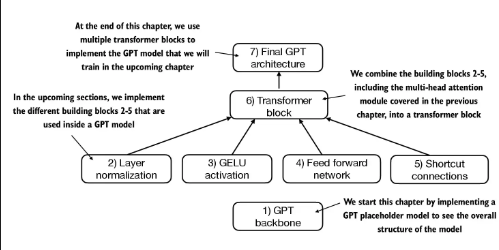

### 1) GPT backbone - a placeholder model

In [3]:
GPT_CONFIG_124M

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [2]:
import torch
import torch.nn as nn 

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb  = nn.Embedding(cfg["vocab_size"], cfg['emb_dim'])
        self.pos_emb  = nn.Embedding(cfg["context_length"], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])


    # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )

    # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(
            cfg["emb_dim"]
        )

        self.out_head   = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds  = self.tok_emb(in_idx)
        pos_embeds  = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
        x  = tok_embeds + pos_embeds
        x  = self.drop_emb(x)
        x  = self.trf_blocks(x)
        x  = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # this block does nothing and just returns its inputs  
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps = 1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface

    def forward(self, x):
        # This layer does nothing and just returns its input. 
        return x


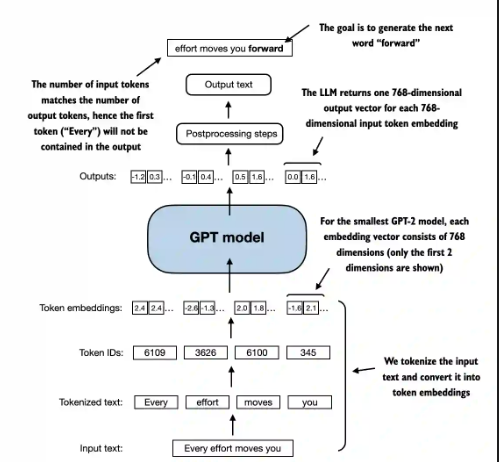

In [6]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = [ ]

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [7]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("output shape:", logits.shape)
print(logits)

output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


### Normalizing activation with layer normalization
- Layer normalization, also known as LayerNorm, centers the activation of a neural network layer around a mean of 0 and normalizes their variance to 1.
- This stabilizes training and enables faster convergence to effective weights
- Layer normalization is applied both before and after the multi-head attention module within the transformer block, which we will implement later; its also applied before the final output layer.
- 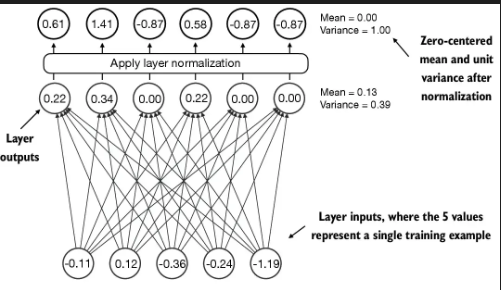
- Lets see how layer normalization works by passing a small input sample throught a simple neural network layer:

In [9]:
torch.manual_seed(123)

#Create 2 tranining examples with 5-d (features) each
batch_example = torch.randn(2,5)

layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out   = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [10]:
layer

Sequential(
  (0): Linear(in_features=5, out_features=6, bias=True)
  (1): ReLU()
)

In [11]:
#Let's compute the mean and variance for each of the 2 inputs above:
mean = out.mean(dim = -1, keepdim=True)
var  = out.var(dim=-1, keepdim=True)

print("mean:\n", mean)
print("variance:\n", var)

mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- The normalization is applied to each of the two inputs(rows) independently; using dim=-1 applies the calculations across the last dimensions(in this case, the feature dim) instead of row dimension
- 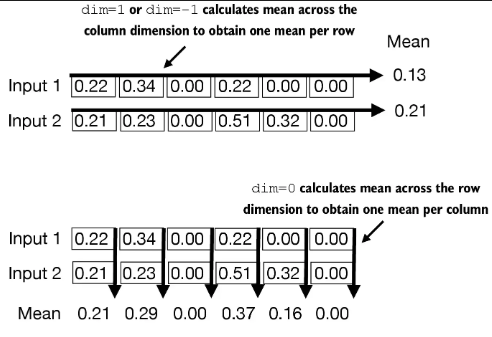

- Substracting the mean and dividing by the square-root of the variance(standard deviation) centers the inputs to have a mean of 0 and a variance of 1 across the column dimensions:

In [12]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim = -1, keepdim = True)
var  = out_norm.var(dim=-1 , keepdim = True)

print("Mean:\n", mean)
print("variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [13]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim= -1, keepdim = True)
        var  = x.var(dim= -1, keepdim = True, unbiased = False)
        norm_x = (x-mean)/torch.sqrt(var + self.eps)
        return self.scale *norm_x + self.shift

In [14]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [15]:
mean = out_ln.mean(dim = -1, keepdim=True)
var = out_ln.var(dim=-1, unbiased= False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


-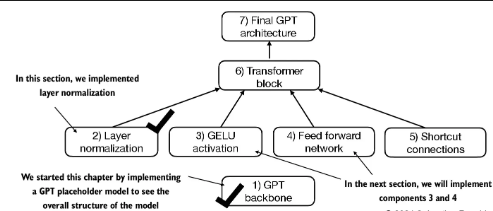

### Implementing a feed forward network with GELU activations
- In this section, we implement a small neural network submodel that is used as a part of the transformer blovk in LLM.
- We start with the activation function.
- In deep learning, ReLU(Rectified Liner Unit) activation functions are commonly used due to their simplicity and effectiveness in various neural network architecture.
- In LLM, various other types of activation functions are used beyond the traditional ReLU; two notable examples are GELU(Gaussian Error Linear Unit) and SwiGLU (Swish-Gated Linear Unit)
- GELU and SwiGLU are more complex, smooth activation functions incorporating Gaussian and sigmoid-gated linear units, respectively, offering better performance for deep learning models, unlike the simpler, piecewise linear functions of ReLU

- GeLU can be implemented in several ways; the exact version is defined as GELU(x) = x⋅Φ(x) , where Φ(x) is the cumulative distribution function of the standard Gaussian distribution.
- In practive, its common to implement a computationally cheaper approx:
 $\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)
$ (the original GPT-2 model was also trained with this approximation)

In [7]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi)) * 
                                  (x + 0.044715 * torch.pow(x, 3))
                     ))

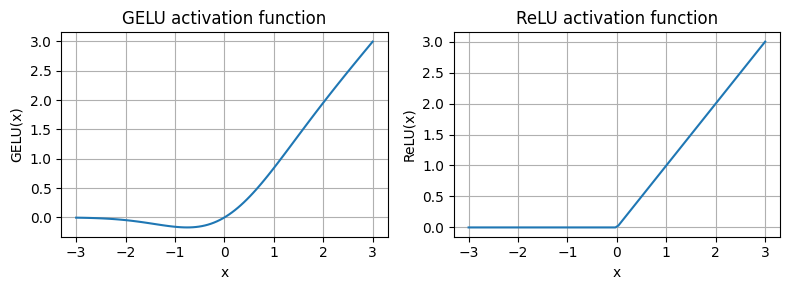

In [8]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8,3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1,2,i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

- As we can see, ReLU is a piecewise linear function that outputs the input directly if it is positive; otherwise, it outputs zero
- GELU is a smooth, non-linear function that approximates ReLU but with a non-zero gradients for negative values
- Next, let's implement the small neural network module, `FeedForward`, that we will be using in the LLM's transformer block later:

In [10]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [9]:
print(GPT_CONFIG_124M["emb_dim"])

768


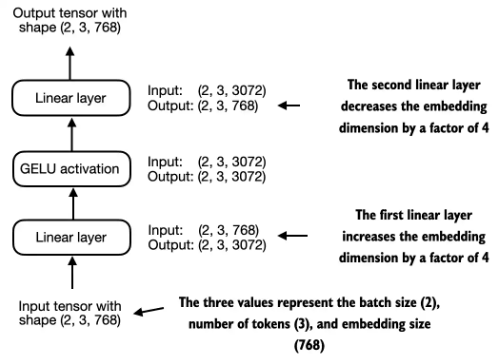

In [11]:
ffn = FeedForward(GPT_CONFIG_124M)

x = torch.rand(2,3,768)
out = ffn(x)

print(out.shape)

torch.Size([2, 3, 768])


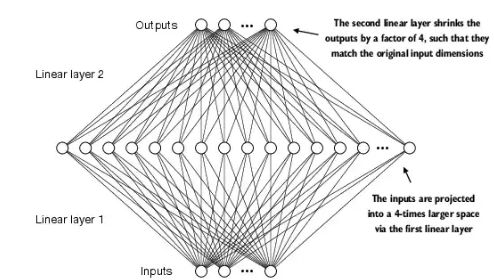
- 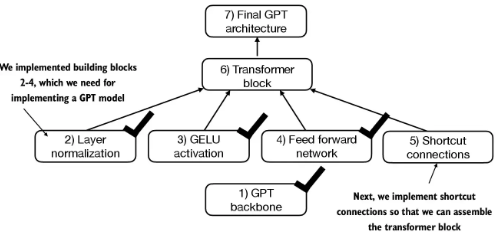

### Adding shortcut connections

- Next lets talk about the concepts behind shortcut connection, also called skip or residual connection.
- Originally, shortcut connections were proposed in deep networks for computervision (residual network) to mitigate vanishing gradients.
- A shortcut connection creates an alternative shorter path for the gradient to flow through the network.
- This is achieved by adding the output of one layer to output of a later layer, usually skipping one or more layers in between.
- let's illustrate this idea with a small example network:
- 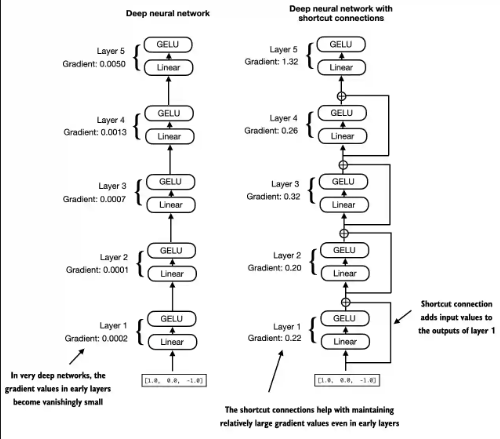

In [ ]:
# nn.ModuleList is a container that holds a list of submodules (like layers in a neural network)
# You can add layers to nn.ModuleList just like you would with a regular Python list, but with the added benefit that PyTorch will recognize and manage these layers properly.

In [3]:
class ExampleDeepNeuralnetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([   #ModuleList is similar to python list 
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
                                    ])
    def forward(self, x):
        for layer in self.layers:
            layer_output=layer(x) # Compute the output of the current layer
            if self.use_shortcut and x.shape == layer_output.shape: # check if shortcut can be applied
                x = x + layer_output
            else:
                x = layer_output
        return x


In [4]:
def print_gradients(model, x):
    output = model(x)                  # Forward Pass
    target = torch.tensor([[0.]])

    loss = nn.MSELoss() #Calculate loss based on how close the target and output are
    loss = loss(output, target)

    loss.backward() #Backward pass to calculate the gradients

    for name, param in model.named_parameters():
        if 'weight' in name:
            #Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [11]:
#Lets print the gradient values first without shortcut connections

layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input= torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralnetwork(layer_sizes, use_shortcut=False)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


In [13]:
#lets print the gradient values with shortcut connections
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralnetwork(
    layer_sizes, use_shortcut = True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


- As we can see based on the output above, shortcut connections prevent the gradients from vabishing in the early layers(towards `layer.0`)
- We will use this concept of a shortcut connection next when we implement a transformer block